# Least Squares Audio Compression using Linear Predictive Coding (LPC)

## 1. Preprocess the Data

In [1]:
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [2]:
# Read in the audio
sample_rate, y = scipy.io.wavfile.read('Kam_James_A10789738_Project1.wav')

# Normalize the signal
y = y/np.max(abs(y))

In [3]:
def float2pcm(sig, dtype='int16'):
    # Prepare the audio signal before exporting
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)

In [4]:
# Obtain a pad size to appropriately zero pad the data
block_size = 160
if y.shape[0] % block_size == 0:
    pad_size = 0
else:
    pad_size = block_size - (y.shape[0] % block_size)

# Zero pad the data
y = np.lib.pad(y, (0, pad_size), 'constant', constant_values = (0, 0))

# Calculate number of blocks
num_blocks = int(y.shape[0]/block_size)

# Reshape the data
y = np.reshape(y, (num_blocks, block_size))

## 2. Quantize the Data

In [5]:
# Initialize the lists used to quantize y

# Create a list of r to iterate through
r_list = list(range(1,9))

# Create list of alpha to iterate through
alpha_list = [0.25, 0.5, 1, 1.5, 2, 2.5, 3]

In [6]:
def quantize(sig, r, alpha, axis):
    # sig is a num_blocks by N array of the signal data
    # r is a quantization rate
    # alpha is a free parameter that adjusts the thresholding range
    # alpha > 0
    # Return sig_q, a quantized version of the original signal
    
    # Transpose sig if axis = 1
    if axis == 1:
        sig = sig.T
    
    num_blocks = sig.shape[0]
    
    # Create L (corresponding to r)
    L = 2**r
    
    # Intialize sig_q
    sig_q = np.zeros(sig.shape)
    
    # Intialize sig_thresh
    sig_thresh = np.zeros(sig.shape)
    
    # Find the mean and standard deviation
    sig_mean = sig.mean(axis = 1)
    sig_std = sig.std(axis = 1)

    # Calculate threshold bounds
    upper_thresh = sig_mean + alpha*sig_std
    lower_thresh = sig_mean - alpha*sig_std
    
    # Compute thresholded signal before quantizing
    for i in range(num_blocks):    
        # Apply threshold
        np.clip(sig[i,:], lower_thresh[i], upper_thresh[i], out = sig_thresh[i,:])
        
        # Calculate q
        q = (np.max(sig_thresh[i,:]) - np.min(sig_thresh[i,:])) / (L - 1)
    
        # Calculate sig_q
        sig_q[i, :] = np.round(sig_thresh[i,:]/q) * q
    
    # Transpose sig_q if axis = 1
    if axis == 1:
        sig_q = sig_q.T
            
    return sig_q

In [7]:
def mse_calc(sig1, sig2):
    from numpy.core.umath_tests import inner1d
    
    # sig1 and sig2 are arrays of the same size
    
    if sig1.shape != sig2.shape:
        raise ValueError("Arrays of size", sig1.shape, "and", sig2.shape, "are unsuitable for comparison")
            
    N = sig1.shape[0]*sig1.shape[1]
    
    # Compute the mse between each block of sig1 and sig2
    error = sig1 - sig2
    sq_error = error**2
    mse = np.sum(sq_error)/N

    return mse

In [8]:
# Initialize y_mse
y_mse = np.zeros([len(r_list), len(alpha_list)])

# Populate y_mse
for i in range(len(r_list)):
    for j in range(len(alpha_list)):
        # Quantize y
        y_q = quantize(y, r_list[i], alpha_list[j], axis = 0)
        
        # Export the sound files
        # title = 'y_q_r=' + str(r_list[i]) + 'alpha=' + str(alpha_list[j]) + '.wav'
        # scipy.io.wavfile.write(title, sample_rate, float2pcm(y_q.flatten(), 'int16'))
        
        # Calculate MSE between y and y_q
        y_mse[i,j] = mse_calc(y, y_q)

In [9]:
def print_mse(sig_mse, alpha_list, r_list):
    # Print a table of MSEs for all alpha and r
    
    # Print column headers
    print("      ", end = "")
    for i in range(len(alpha_list)):
        if i != len(alpha_list) - 1:
            end_code = "   "
        else:
            end_code = "\n"
        print("alpha=%.1f" % alpha_list[i], end = end_code)

    # Print column divider
    print("     ", end = "")
    print("-"*(1 + 9*len(alpha_list) + 3*(len(alpha_list)-1)))

    for i in range(len(r_list)):
        # Print row headers
        print("r=%d |" % r_list[i], end = " ")

        # Print entry data
        for j in range(len(alpha_list)):
            if j != len(alpha_list) - 1:
                end_code = "   "
            else:
                end_code = "\n"
            print("%.7f" % sig_mse[i, j], end = end_code)
    return

In [10]:
def mse_vs_r(mse, r_list, alpha_list, alpha):
    fig = plt.figure()
    alpha_index = alpha_list.index(alpha)
    plt.plot(r_list, mse[:, alpha_index])
    
    ax = fig.add_subplot(111)
    
     # Label axes
    ax.set_xlabel('$r$')
    ax.set_ylabel('$MSE$')
    
    plt.tick_params(axis='both', which='major')
    
    # Title plot
    plt.title('$MSE\ vs.\ r,\ \\alpha='+str(alpha)+'$')
    plt.show()

In [11]:
def mse_vs_alpha(mse, r_list, alpha_list, r):
    fig = plt.figure()
    r_index = r_list.index(r)
    plt.plot(alpha_list, mse[r_index, :])
    
    ax = fig.add_subplot(111)
    
     # Label axes
    ax.set_xlabel('$\\alpha$')
    ax.set_ylabel('$MSE$')
    
    plt.tick_params(axis='both', which='major')
    
    # Title plot
    plt.title('$MSE\ vs.\ \\alpha,\ r='+str(r)+'$')
    plt.show()

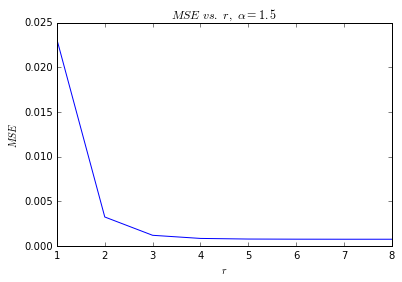

In [12]:
# Plot MSE vs r
alpha_best = 1.5
mse_vs_r(y_mse, r_list, alpha_list, alpha_best)

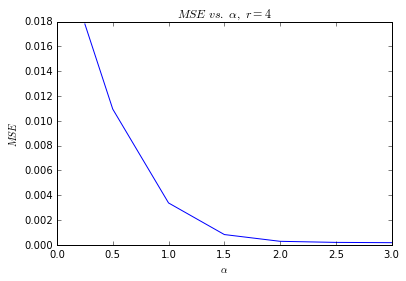

In [13]:
# Plot MSE vs alpha
r_best = 4
mse_vs_alpha(y_mse, r_list, alpha_list, r_best)

In [14]:
def plot_mse(mse, alpha_list, r_list, z_label):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = alpha_list
    Y = r_list
    X, Y = np.meshgrid(X, Y)
    Z = mse
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    
    plt.tick_params(axis='both', which='major')

    # Label axes
    ax.set_xlabel('$\\alpha$')
    ax.set_ylabel('$r$')
    ax.set_zlabel('$MSE_{y,'+z_label+'}$')
        
    # Title plot
    plt.title('$MSE_{y,'+z_label+'}\ vs.\ \\alpha\ vs.\ r$')
    
    plt.show()

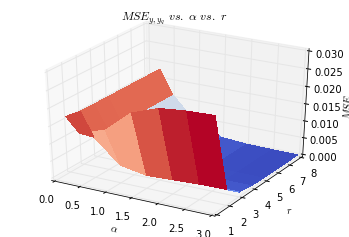

In [15]:
# Plot the 3D MSE
plot_mse(y_mse, alpha_list, r_list, 'y_q')

## 3. Estimate Filter Coefficients / 4. Calculate Residuals

In [16]:
# Implements mldivide (given by \ operator in MatLab)

def mldivide(A,b):
    import numpy as np
    from itertools import combinations
    num_vars = A.shape[1]
    rank = np.linalg.matrix_rank(A)
    if rank == num_vars:              
        sol = np.linalg.lstsq(A, b)[0]    # not underdetermined
        return sol
    else:
        for nz in combinations(range(num_vars), rank):
            try: 
                sol = np.zeros((num_vars, 1))  
                sol[nz, :] = np.asarray(np.linalg.solve(A[:, nz], b))
            except np.linalg.LinAlgError:     
                pass                    # Bad variables, can't solve
        return sol

In [17]:
from scipy.linalg import toeplitz

# Initialize filter order
l = 10

# Initialize array of coefficients
a = np.zeros([l, num_blocks])

# Initialize array of residuals
e = np.zeros([block_size, num_blocks])

# Intialize the l previous data points
prev_y = np.zeros(l)

# Estimate filter coefficients for each block
for i in range(num_blocks):
    # Intialize b
    b = y[i,:]
    
    # Initialize toeplitz matrix
    col_A = y[i,:]
    col_A = np.roll(col_A, 1)
    col_A[0] = prev_y[0]
    row_A = prev_y
    A = scipy.linalg.toeplitz(col_A, row_A)
    
    # Calculate coefficients
    a[:, i] = mldivide(A,b)
    
    # Calculate residuals
    e[:, i] = b - (A @ a[:, i]) 
        
    # Update prev_y with last l entries of current block
    prev_y = y[i, -l::]
    
    # Reverse the order
    prev_y = prev_y[::-1]

In [18]:
print('Dynamic range of residuals:')
print('Max = {}'.format(np.max(e)))
print('Min = {}'.format(np.min(e)))

print('Dynamic range of original signal:')
print('Max = {}'.format(np.max(y)))
print('Min = {}'.format(np.min(y)))

Dynamic range of residuals:
Max = 0.13977243533870964
Min = -0.11001098182316282
Dynamic range of original signal:
Max = 1.0
Min = -0.9450527704485489


## 5. FIR Digital Filter to Calculate Residuals
Calculate e(n) from y(n) and filter coefficients learned in Step 3

$e(n) = y - \hat{y}(n) = y(n) - \sum_{k=1}^{l}{a(k)y(n-k)} $

This is an FIR moving average digital filter

In [19]:
# Initialize array of residuals
e_fir = np.zeros([block_size, num_blocks])

# Intialize previous l data points
prev_y = np.zeros(l)

for i in range(num_blocks):
    for j in range(block_size):
        e_fir[j, i] = y[i, j] - (a[:, i] @ prev_y)
        
        # Update prev_y
        prev_y = np.roll(prev_y, 1)
        prev_y[0] = y[i, j]

Compute MSE between e and e_fir

In [20]:
e_mse = mse_calc(e, e_fir)
print("MSE between residuals from Step 4 and 5 is {}".format(e_mse))

MSE between residuals from Step 4 and 5 is 2.914725335593956e-32


## 6. Autoregressive Filter for Reconstruction
Reconstruct the audio data using the equation:
$ y(n) = \sum ^l _{k=1} {a(k)y(n-k)+e(n)}$
and the residuals computed in Steps 4 and 5. Check that the MSE between the original and reconstructed audio is zero.

In [21]:
def ar_filter(a, e):
    # Autoregressive filter to reconstruct the signal
    # a is an array of filter coefficients of size l by num_blocks
    # e is an array of residuals of size N by num_blocks
    
    # Extract block_size and num_blocks
    [block_size, num_blocks] = e.shape
    l = a.shape[0];
    
    # Intialize y_recons
    y_recons = np.zeros([num_blocks, block_size])

    # Intialize prev_y
    prev_y = np.zeros(l)
    
    for i in range(num_blocks):
        for j in range(block_size):
            y_recons[i, j] = a[:, i] @ prev_y + e[j, i]

            # Update prev_y
            prev_y = np.roll(prev_y, 1)
            prev_y[0] = y_recons[i, j]
    
    return y_recons

In [22]:
y_recons = ar_filter(a, e)
y_recons_mse = mse_calc(y, y_recons)
print('MSE between original audio and reconstructed audio from Step 6 is: {}'.format(y_recons_mse))

MSE between original audio and reconstructed audio from Step 6 is: 8.439024995540207e-29


### 7. Quantization of Residuals / 8. MSE of Directly Quantized Signals vs Reconstructed Estimates
Quantize the residuals using the same quantization rates and procedures as in Step 2. 

Reconstruct an estimate $\hat y$ of the original signal using the AR filter from Step 6.

Calculate the MSE of the original audio and its reconstructed estimates.

Plot the directly quantized MSE and the indirectly quantized MSE vs quantization rate and $\alpha$

In [23]:
# Initialize y_hat_mse of size r_list by alpha_list
y_hat_mse = np.zeros([len(r_list), len(alpha_list)])

# Populate y_hat_mse
for i in range(len(r_list)):
    for j in range(len(alpha_list)):
        # Quantize e
        e_q = quantize(e, r_list[i], alpha_list[j], axis = 1)
        
        # Reconstruct y
        y_hat = ar_filter(a, e_q)
        
        # Export the sound files
        # title = 'y_hat_r=' + str(r_list[i]) + 'alpha=' + str(alpha_list[j]) + '.wav'
        # scipy.io.wavfile.write(title, sample_rate, float2pcm(y_hat.flatten(), 'int16'))
        
        # Calculate MSE between y and y_q
        y_hat_mse[i, j] = mse_calc(y, y_hat)

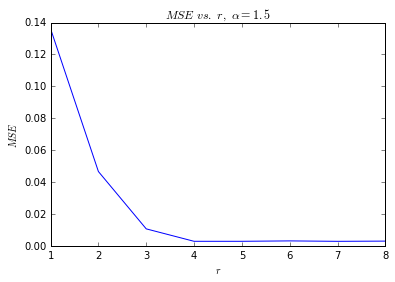

In [24]:
# Plot MSE vs r
alpha_best = 1.5
mse_vs_r(y_hat_mse, r_list, alpha_list, alpha_best)

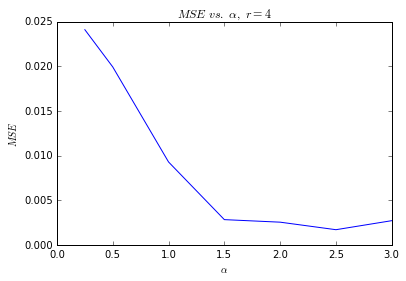

In [25]:
# Plot MSE vs alpha
r_best = 4
mse_vs_alpha(y_hat_mse, r_list, alpha_list, r_best)

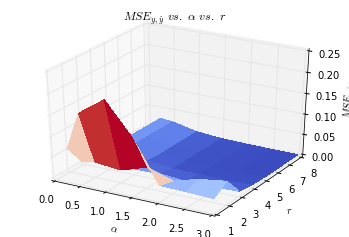

In [26]:
# Plot the 3D MSE
plot_mse(y_hat_mse, alpha_list, r_list, '\hat y')

### 9. Quantization of Coefficients
Quantize the filter coefficients determined in Step 3.

Repeats Step 7 and 8, replacing $a(k)$ by its quantized form $a_q(k)$

In [27]:
r_list = [4, 8, 9]
alpha_list = [0.5, 1, 2, 4, 9]

# Quantize the filter coefficients
# Initialize y_hat_mse of size r_list by alpha_list
y_a_mse = np.zeros([len(r_list), len(alpha_list)])

# Populate y_a_mse
for i in range(len(r_list)):
    for j in range(len(alpha_list)):
        # Quantize e
        e_q = quantize(e, r_list[i], alpha_list[j], axis = 1)
        
        # Quantize a
        a_q = quantize(a, r_list[i], alpha_list[j], axis = 1) 
        # Reconstruct y
        y_a = ar_filter(a_q, e_q)
        
        
        # Export the sound files
        # title = 'y_a_r=' + str(r_list[i]) + 'alpha=' + str(alpha_list[j]) + '.wav'
        # scipy.io.wavfile.write(title, sample_rate, float2pcm(y_a.flatten(), 'int16'))
        
        # Calculate MSE between y and y_q
        y_a_mse[i, j] = mse_calc(y, y_a)

# Print and plot MSE
print_mse(y_a_mse, alpha_list, r_list)
plot_mse(y_a_mse, alpha_list, r_list, '$y_a$')